<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
stn_code                       291665 non-null object
sampling_date                  435739 non-null object
state                          435742 non-null object
location                       435739 non-null object
agency                         286261 non-null object
type                           430349 non-null object
so2                            401096 non-null float64
no2                            419509 non-null float64
rspm                           395520 non-null float64
spm                            198355 non-null float64
location_monitoring_station    408251 non-null object
pm2_5                          9314 non-null float64
date                           435735 non-null object
dtypes: float64(5), object(8)
memory usage: 43.2+ MB
R-squared (R2) Score: 0.9847286394495923


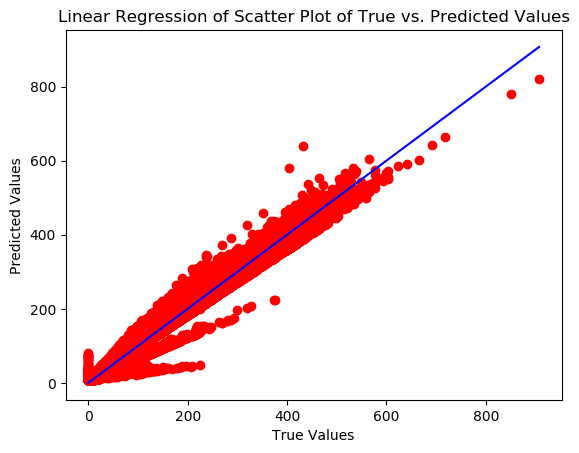

RMSE TestData =  1.1522526187065387
RSquared value on test: 0.999891545021887
R-squared (R2) Score: 0.999891545021887


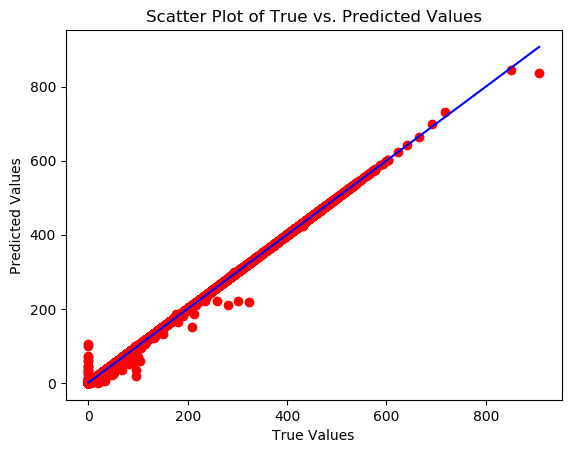

            Actual   Predicted
17593    17.500000   17.500000
134413   41.250000   41.250000
360229   31.250000   31.249998
358484   17.500000   17.500000
265920    6.250000    6.250000
...            ...         ...
69766   258.000000  258.000000
391744   26.250000   26.250000
10306   154.666667  154.666667
275551  147.333333  147.333333
372655  279.000000  279.000000

[87149 rows x 2 columns]


In [ ]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix


df = pd.read_csv(r"data.csv", encoding='unicode_escape')

# Data Analysis

df.head()
df.shape
df.info()
df.isnull().sum()
df.describe()

df.state.unique()
df.state.count()

df.nunique()

df.drop(['agency'], axis=1, inplace=True)
df.drop(['stn_code'], axis=1, inplace=True)
df.drop(['date'], axis=1, inplace=True)
df.drop(['sampling_date'], axis=1, inplace=True)
df.drop(['location_monitoring_station'], axis=1, inplace=True)

df.isnull().sum()

df['location'] = df['location'].fillna(df['location'].mode()[0])
df['type'] = df['type'].fillna(df['type'].mode()[0])

df.fillna(0, inplace=True)

df.isnull().sum()

df

# Calculate SO2

def cal_SOi(so2):
    si = 0
    if (so2 <= 40):
        si = so2 * (50 / 40)
    elif (so2 > 40 and so2 <= 80):
        si = 50 + (so2 - 40) * (50 / 40)
    elif (so2 > 80 and so2 <= 380):
        si = 100 + (so2 - 80) * (100 / 300)
    elif (so2 > 380 and so2 <= 800):
        si = 200 + (so2 - 380) * (100 / 420)
    elif (so2 > 800 and so2 <= 1600):
        si = 300 + (so2 - 800) * (100 / 800)
    elif (so2 > 1600):
        si = 400 + (so2 - 1600) * (100 / 800)
    return si

df['SOi'] = df['so2'].apply(cal_SOi)
data = df[['so2', 'SOi']]
data.head()

# Calculate NO2

def cal_Noi(no2):
    ni = 0
    if (no2 <= 40):
        ni = no2 * 50 / 40
    elif (no2 > 40 and no2 <= 80):
        ni = 50 + (no2 - 40) * (50 / 40)
    elif (no2 > 80 and no2 <= 180):
        ni = 100 + (no2 - 80) * (100 / 100)
    elif (no2 > 180 and no2 <= 280):
        ni = 200 + (no2 - 180) * (100 / 100)
    elif (no2 > 280 and no2 <= 400):
        ni = 300 + (no2 - 280) * (100 / 120)
    else:
        ni = 400 + (no2 - 400) * (100 / 120)
    return ni

df['Noi'] = df['no2'].apply(cal_Noi)
data = df[['no2', 'Noi']]
data.head()

# Calculate RSPM

def cal_RSPMI(rspm):
    rpi = 0
    if (rpi <= 30):
        rpi = rpi * 50 / 30
    elif (rpi > 30 and rpi <= 60):
        rpi = 50 + (rpi - 30) * 50 / 30
    elif (rpi > 60 and rpi <= 90):
        rpi = 100 + (rpi - 60) * 100 / 30
    elif (rpi > 90 and rpi <= 120):
        rpi = 200 + (rpi - 90) * 100 / 30
    elif (rpi > 120 and rpi <= 250):
        rpi = 300 + (rpi - 120) * (100 / 130)
    else:
        rpi = 400 + (rpi - 250) * (100 / 130)
    return rpi

df['Rpi'] = df['rspm'].apply(cal_RSPMI)
data = df[['rspm', 'Rpi']]
data.head()

# Calculate SPM

def cal_SPMi(spm):
    spi = 0
    if (spm <= 50):
        spi = spm * 50 / 50
    elif (spm > 50 and spm <= 100):
        spi = 50 + (spm - 50) * (50 / 50)
    elif (spm > 100 and spm <= 250):
        spi = 100 + (spm - 100) * (100 / 150)
    elif (spm > 250 and spm <= 350):
        spi = 200 + (spm - 250) * (100 / 100)
    elif (spm > 350 and spm <= 430):
        spi = 300 + (spm - 350) * (100 / 80)
    else:
        spi = 400 + (spm - 430) * (100 / 430)
    return spi

df['SPMi'] = df['spm'].apply(cal_SPMi)
data = df[['spm', 'SPMi']]
data.head()

# Air Quality Index (AQI)

def cal_aqi(si, ni, rspmi, spmi):
    aqi = 0
    if (si > ni and si > rspmi and si > spmi):
        aqi = si
    if (ni > si and ni > rspmi and ni > spmi):
        aqi = ni
    if (rspmi > si and rspmi > ni and rspmi > spmi):
        aqi = rspmi
    if (spmi > si and spmi > ni and spmi > rspmi):
        aqi = spmi
    return aqi

df['AQI'] = df.apply(lambda x: cal_aqi(x['SOi'], x['Noi'], x['Rpi'], x['SPMi']), axis=1)
data = df[['state', 'SOi', 'Noi', 'Rpi', 'SPMi', 'AQI']]
data.head()

def AQI_Range(x):
    if x <= 50:
        return "Good"
    elif 50 < x <= 100:
        return "Moderate"
    elif 100 < x <= 200:
        return "Poor"
    elif 200 < x <= 300:
        return "Unhealthy"
    elif 300 < x <= 400:
        return "Very unhealthy"
    elif x > 400:
        return "Hazardous"

df['AQI_Range'] = df['AQI'].apply(AQI_Range)
df.head()

X = df[['SOi', 'Noi', 'Rpi', 'SPMi']]
Y = df['AQI']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=70)

model = LinearRegression()
model.fit(X_train, Y_train)

# Predicting on test
test_pred = model.predict(X_test)

# Calculate R-squared (R2) Score
r2 = r2_score(Y_test, test_pred)
print("R-squared (R2) Score:", r2)

# Create a scatter plot of the true target values (Y_test) against the predicted target values (Y_pred)
plt.scatter(Y_test, test_pred, color='red')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='blue')  # Diagonal line for comparison
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression of Scatter Plot of True vs. Predicted Values')
plt.show()

RF = RandomForestRegressor().fit(X_train, Y_train)

# Predicting on test
test_preds1 = RF.predict(X_test)

RMSE_test = (np.sqrt(metrics.mean_squared_error(Y_test, test_preds1)))
print("RMSE TestData = ", str(RMSE_test))
print('RSquared value on test:', RF.score(X_test, Y_test))

# Calculate R-squared (R2) Score
r2 = r2_score(Y_test, test_preds1)
print("R-squared (R2) Score:", r2)

# Create a scatter plot of the true target values (Y_test) against the predicted target values (Y_pred)
plt.scatter(Y_test, test_preds1, color='red')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='blue')  # Diagonal line for comparison
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.show()

# Create a DataFrame with the actual and predicted values
df = pd.DataFrame({'Actual': Y_test, 'Predicted': test_preds1})

# Print the DataFrame
print(df)

# Predicting AQI for custom input

SOi = float(input("Enter the value of SOI:"))
NOi = float(input("Enter the value of NOI:"))
RPi = float(input("Enter the value of RPI:"))
SPM = float(input("Enter the value of SPM:"))

# Create a numpy array with the input values
input_data = np.array([[SOi, NOi, RPi, SPM]])

# Make predictions using the trained model
predicted_value = RF.predict(input_data)

# Print the predicted value
print("Predicted Value:", predicted_value[0])

if predicted_value <= 50:
    print("AIR Quality is predicated as --> Good")
elif 50 < predicted_value <= 100:
    print("AIR Quality is predicated as --> Moderate")
elif 100 < predicted_value <= 200:
    print("AIR Quality is predicated as --> Poor")
elif 200 < predicted_value <= 300:
    print("AIR Quality is predicated as --> Unhealthy")
elif 300 < predicted_value <= 400:
    print("AIR Quality is predicated as --> Very unhealthy")
elif predicted_value > 400:
    print("AIR Quality is predicated as --> Hazardous")


In [2]:
# Save the Random Forest Regressor model to a file using joblib
import joblib

# Assuming you have the trained RF model stored in the 'RF' variable
joblib.dump(RF, 'random_forest_model.joblib') 

['random_forest_model.joblib']